In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

def csv2labelnp(csv_file):
    label_df = pd.read_csv(csv_file, header=None)
    return label_df.loc[:,2:].to_numpy() / 10

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FERPlusDataset(Dataset):
    def __init__(self, root, mode, threshold=0.3, transform=None):
        self.labels = csv2labelnp(os.path.join(root, 'label.csv'))
        self.samples = [os.path.join(root, img_name) for img_name in sorted(os.listdir(root))[:-1]]
        self.mode = mode
        self.threshold = threshold
        self.transform = transform
    
    def __getitem__(self, idx):
        img = pil_loader(self.samples[idx])
        if self.transform:
            img = self.transform(img)
        target = self.labels[idx]
        if self.mode == 'majority':
            target = np.argmax(target)
            target = torch.tensor(target)
        elif self.mode == 'multi-label':
            target = (target > self.threshold).astype(int)
            target = torch.from_numpy(target)
        else:
            target = torch.from_numpy(target)
        return img, target
    
    def __len__(self):
        return len(self.samples)

In [4]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor,
                                    RandomAffine)

normalize = Normalize(mean=sum(feature_extractor.image_mean) / len(feature_extractor.image_mean),
                      std=sum(feature_extractor.image_std) / len(feature_extractor.image_std))

train_transform = Compose([RandomAffine(30),
                           Resize(tuple(feature_extractor.size.values())),
                           ToTensor()])

val_test_transform = Compose([Resize(tuple(feature_extractor.size.values())),
                              ToTensor()])

mode = 'majority'

train_dataset = FERPlusDataset('FERPlus/data/FER2013Train',
                               mode,
                               transform=train_transform)
val_dataset = FERPlusDataset('FERPlus/data/FER2013Valid',
                             mode,
                             transform=val_test_transform)
test_dataset = FERPlusDataset('FERPlus/data/FER2013Test',
                              mode,
                              transform=val_test_transform)

print('train:', len(train_dataset))
print('val:', len(val_dataset))
print('test:', len(test_dataset))

train: 28558
val: 3579
test: 3573


In [5]:
def collate_fn(examples):
    imgs, labels = zip(*examples)
    pixel_values = torch.stack(imgs)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'labels': labels}

In [6]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [7]:
id2label = {
    0: 'neutral',
    1: 'happiness',
    2: 'surprise',
    3: 'sadness',
    4: 'anger',
    5: 'disgust',
    6: 'fear',
    7: 'contempt',
    8: 'unknown',
    9: 'NF'
}
label2id = {v:k for k,v in id2label.items()}

label2id

{'neutral': 0,
 'happiness': 1,
 'surprise': 2,
 'sadness': 3,
 'anger': 4,
 'disgust': 5,
 'fear': 6,
 'contempt': 7,
 'unknown': 8,
 'NF': 9}

In [8]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(label2id),
                                                  label2id=label2id,
                                                  id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"fer-majority-vit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [10]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_461950/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
label_ratio = torch.tensor([0]*len(id2label))
for _, label in train_dataset:
    label = label.tolist()
    label_ratio[label] += 1
label_ratio = label_ratio / len(train_dataset)
weight = (1 / label_ratio).clone().to(device, torch.float32)
log_weight = (-torch.log(label_ratio)).clone().to(device, torch.float32)
log_weight[-2] = log_weight[-1] = 1
print(weight)
print(log_weight)

tensor([2.7740e+00, 3.7946e+00, 8.0287e+00, 8.0901e+00, 1.1595e+01, 1.4952e+02,
        4.3600e+01, 1.6999e+02, 1.6701e+02, 1.4279e+04], device='cuda:0')
tensor([1.0203, 1.3336, 2.0830, 2.0906, 2.4506, 5.0074, 3.7751, 5.1357, 1.0000,
        1.0000], device='cuda:0')


In [12]:
import torch.nn as nn
from torch.utils.data.sampler import WeightedRandomSampler

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class WeightedRandomSamplerTrainer(Trainer):
    def get_train_dataloader(self) -> DataLoader:
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        data_collator = self.data_collator
        return DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=WeightedRandomSampler(weights=weight, num_samples=len(train_dataset)),
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

In [13]:
trainer = WeightedLossTrainer(
# trainer = WeightedRandomSamplerTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [14]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28558
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8930
  Number of trainable parameters = 85806346
  6%|▌         | 500/8930 [02:32<42:17,  3.32it/s]

{'loss': 1.8302, 'learning_rate': 1.888017917133259e-05, 'epoch': 0.56}


 10%|█         | 893/8930 [04:30<33:15,  4.03it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                  
 10%|█         | 893/8930 [04:44<33:15,  4.03it/s]Saving model checkpoint to fer-majority-vit/checkpoint-893
Configuration saved in fer-majority-vit/checkpoint-893/config.json


{'eval_loss': 1.2074694633483887, 'eval_accuracy': 0.7292539815590947, 'eval_runtime': 13.2251, 'eval_samples_per_second': 270.621, 'eval_steps_per_second': 33.875, 'epoch': 1.0}


Model weights saved in fer-majority-vit/checkpoint-893/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-893/preprocessor_config.json
 11%|█         | 1000/8930 [05:22<38:40,  3.42it/s]  

{'loss': 1.4318, 'learning_rate': 1.7760358342665175e-05, 'epoch': 1.12}


 17%|█▋        | 1500/8930 [07:51<37:35,  3.29it/s]

{'loss': 1.279, 'learning_rate': 1.6640537513997762e-05, 'epoch': 1.68}


 20%|██        | 1786/8930 [09:18<30:57,  3.85it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 20%|██        | 1786/8930 [09:31<30:57,  3.85it/s]Saving model checkpoint to fer-majority-vit/checkpoint-1786
Configuration saved in fer-majority-vit/checkpoint-1786/config.json


{'eval_loss': 1.007039189338684, 'eval_accuracy': 0.7404302877898854, 'eval_runtime': 13.521, 'eval_samples_per_second': 264.7, 'eval_steps_per_second': 33.134, 'epoch': 2.0}


Model weights saved in fer-majority-vit/checkpoint-1786/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-1786/preprocessor_config.json
 22%|██▏       | 2000/8930 [10:43<34:36,  3.34it/s]   

{'loss': 1.1537, 'learning_rate': 1.552071668533035e-05, 'epoch': 2.24}


 28%|██▊       | 2500/8930 [13:12<32:08,  3.33it/s]

{'loss': 1.061, 'learning_rate': 1.4400895856662935e-05, 'epoch': 2.8}


 30%|███       | 2679/8930 [14:06<27:07,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 30%|███       | 2679/8930 [14:20<27:07,  3.84it/s]Saving model checkpoint to fer-majority-vit/checkpoint-2679
Configuration saved in fer-majority-vit/checkpoint-2679/config.json


{'eval_loss': 0.8996833562850952, 'eval_accuracy': 0.7706063146130204, 'eval_runtime': 13.4763, 'eval_samples_per_second': 265.577, 'eval_steps_per_second': 33.244, 'epoch': 3.0}


Model weights saved in fer-majority-vit/checkpoint-2679/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-2679/preprocessor_config.json
 34%|███▎      | 3000/8930 [16:04<30:18,  3.26it/s]   

{'loss': 0.9916, 'learning_rate': 1.3281075027995522e-05, 'epoch': 3.36}


 39%|███▉      | 3500/8930 [18:35<26:54,  3.36it/s]

{'loss': 0.9333, 'learning_rate': 1.2161254199328107e-05, 'epoch': 3.92}


 40%|████      | 3572/8930 [18:56<22:19,  4.00it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 40%|████      | 3572/8930 [19:09<22:19,  4.00it/s]Saving model checkpoint to fer-majority-vit/checkpoint-3572
Configuration saved in fer-majority-vit/checkpoint-3572/config.json


{'eval_loss': 0.8445628881454468, 'eval_accuracy': 0.7829002514668902, 'eval_runtime': 13.24, 'eval_samples_per_second': 270.317, 'eval_steps_per_second': 33.837, 'epoch': 4.0}


Model weights saved in fer-majority-vit/checkpoint-3572/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-3572/preprocessor_config.json
 45%|████▍     | 4000/8930 [21:24<25:11,  3.26it/s]  

{'loss': 0.8604, 'learning_rate': 1.1041433370660695e-05, 'epoch': 4.48}


 50%|█████     | 4465/8930 [23:45<18:58,  3.92it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 50%|█████     | 4465/8930 [23:58<18:58,  3.92it/s]Saving model checkpoint to fer-majority-vit/checkpoint-4465
Configuration saved in fer-majority-vit/checkpoint-4465/config.json


{'eval_loss': 0.806887686252594, 'eval_accuracy': 0.7982676725342275, 'eval_runtime': 13.3846, 'eval_samples_per_second': 267.397, 'eval_steps_per_second': 33.471, 'epoch': 5.0}


Model weights saved in fer-majority-vit/checkpoint-4465/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-4465/preprocessor_config.json
 50%|█████     | 4500/8930 [24:15<22:20,  3.31it/s]  

{'loss': 0.8227, 'learning_rate': 9.921612541993282e-06, 'epoch': 5.04}


 56%|█████▌    | 5000/8930 [26:44<19:22,  3.38it/s]

{'loss': 0.7609, 'learning_rate': 8.801791713325869e-06, 'epoch': 5.6}


 60%|██████    | 5358/8930 [28:30<15:07,  3.94it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 60%|██████    | 5358/8930 [28:44<15:07,  3.94it/s]Saving model checkpoint to fer-majority-vit/checkpoint-5358
Configuration saved in fer-majority-vit/checkpoint-5358/config.json


{'eval_loss': 0.8158136606216431, 'eval_accuracy': 0.8044146409611623, 'eval_runtime': 13.3117, 'eval_samples_per_second': 268.861, 'eval_steps_per_second': 33.655, 'epoch': 6.0}


Model weights saved in fer-majority-vit/checkpoint-5358/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-5358/preprocessor_config.json
 62%|██████▏   | 5500/8930 [29:33<17:02,  3.36it/s]  

{'loss': 0.7393, 'learning_rate': 7.681970884658456e-06, 'epoch': 6.16}


 67%|██████▋   | 6000/8930 [32:03<14:33,  3.35it/s]

{'loss': 0.6729, 'learning_rate': 6.562150055991042e-06, 'epoch': 6.72}


 70%|███████   | 6251/8930 [33:18<11:09,  4.00it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 70%|███████   | 6251/8930 [33:31<11:09,  4.00it/s]Saving model checkpoint to fer-majority-vit/checkpoint-6251
Configuration saved in fer-majority-vit/checkpoint-6251/config.json


{'eval_loss': 0.7966660857200623, 'eval_accuracy': 0.8005029337803856, 'eval_runtime': 13.2242, 'eval_samples_per_second': 270.64, 'eval_steps_per_second': 33.877, 'epoch': 7.0}


Model weights saved in fer-majority-vit/checkpoint-6251/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-6251/preprocessor_config.json
 73%|███████▎  | 6500/8930 [34:52<12:16,  3.30it/s]  

{'loss': 0.675, 'learning_rate': 5.442329227323628e-06, 'epoch': 7.28}


 78%|███████▊  | 7000/8930 [37:24<09:48,  3.28it/s]

{'loss': 0.6344, 'learning_rate': 4.322508398656216e-06, 'epoch': 7.84}


 80%|████████  | 7144/8930 [38:08<07:44,  3.85it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 80%|████████  | 7144/8930 [38:22<07:44,  3.85it/s]Saving model checkpoint to fer-majority-vit/checkpoint-7144
Configuration saved in fer-majority-vit/checkpoint-7144/config.json


{'eval_loss': 0.791093111038208, 'eval_accuracy': 0.8100027940765577, 'eval_runtime': 13.4797, 'eval_samples_per_second': 265.51, 'eval_steps_per_second': 33.235, 'epoch': 8.0}


Model weights saved in fer-majority-vit/checkpoint-7144/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-7144/preprocessor_config.json
 84%|████████▍ | 7500/8930 [40:15<07:08,  3.34it/s]  

{'loss': 0.583, 'learning_rate': 3.202687569988802e-06, 'epoch': 8.4}


 90%|████████▉ | 8000/8930 [42:44<04:40,  3.31it/s]

{'loss': 0.5548, 'learning_rate': 2.082866741321389e-06, 'epoch': 8.96}


 90%|█████████ | 8037/8930 [42:55<03:47,  3.93it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 90%|█████████ | 8037/8930 [43:08<03:47,  3.93it/s]Saving model checkpoint to fer-majority-vit/checkpoint-8037
Configuration saved in fer-majority-vit/checkpoint-8037/config.json


{'eval_loss': 0.7849414348602295, 'eval_accuracy': 0.8074881251746298, 'eval_runtime': 13.3738, 'eval_samples_per_second': 267.613, 'eval_steps_per_second': 33.498, 'epoch': 9.0}


Model weights saved in fer-majority-vit/checkpoint-8037/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-8037/preprocessor_config.json
 95%|█████████▌| 8500/8930 [45:34<02:10,  3.30it/s]  

{'loss': 0.5378, 'learning_rate': 9.630459126539753e-07, 'epoch': 9.52}


100%|██████████| 8930/8930 [47:41<00:00,  3.98it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
100%|██████████| 8930/8930 [47:54<00:00,  3.98it/s]Saving model checkpoint to fer-majority-vit/checkpoint-8930
Configuration saved in fer-majority-vit/checkpoint-8930/config.json


{'eval_loss': 0.7842400074005127, 'eval_accuracy': 0.8094439787650182, 'eval_runtime': 13.0871, 'eval_samples_per_second': 273.475, 'eval_steps_per_second': 34.232, 'epoch': 10.0}


Model weights saved in fer-majority-vit/checkpoint-8930/pytorch_model.bin
Image processor saved in fer-majority-vit/checkpoint-8930/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from fer-majority-vit/checkpoint-7144 (score: 0.8100027940765577).
100%|██████████| 8930/8930 [48:01<00:00,  3.10it/s]

{'train_runtime': 2881.1404, 'train_samples_per_second': 99.12, 'train_steps_per_second': 3.099, 'train_loss': 0.8950281482794784, 'epoch': 10.0}


TrainOutput(global_step=8930, training_loss=0.8950281482794784, metrics={'train_runtime': 2881.1404, 'train_samples_per_second': 99.12, 'train_steps_per_second': 3.099, 'train_loss': 0.8950281482794784, 'epoch': 10.0})

In [15]:
outputs = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 3573
  Batch size = 8
100%|██████████| 447/447 [00:13<00:00, 33.89it/s]


In [16]:
print(outputs.metrics)

{'test_loss': 0.8740112781524658, 'test_accuracy': 0.7982087881332214, 'test_runtime': 13.2241, 'test_samples_per_second': 270.188, 'test_steps_per_second': 33.802}


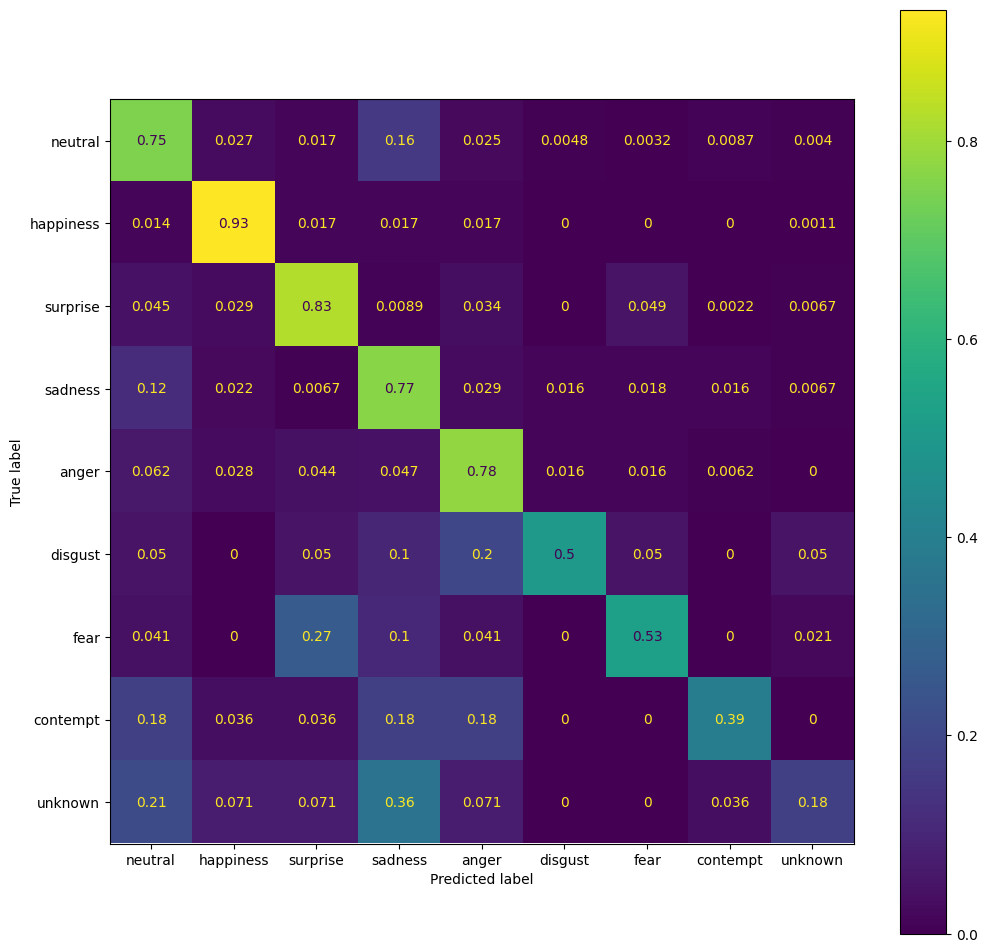

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())[:-1]
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)